In [173]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score,mean_squared_error
import seaborn as sns
from sklearn.metrics import accuracy_score,classification_report, mean_absolute_error, mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
np.random.seed(123)
import sklearn as sk
from sklearn.svm import SVR
from model import SVR

time series shape: (295, 1)
trainX shape is (142, 5)
trainY shape is (142, 1)
testX shape is (143, 5)
testY shape is (143, 1)
test MAE 8265.637500874258
test RMSE 12379.883264538514
test MAPE 51.626007173713305
test SMAPE 39.684787185345996


C:\Users\Nirachaa\anaconda3\envs\travel_time\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


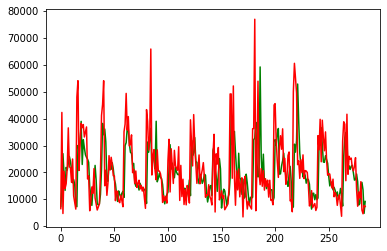

In [174]:
def SVR_forecasting(dataset, lookBack, C=2.0, epsilon=0.01, plot_flag=False):

    # normalize time series
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)

    # divide the series into training/testing samples
    # NOTE: Not RNN format
    train,test = divideTrainTest(dataset,rate=0.5)

    trainX, trainY = createSamples(train, lookBack, RNN=False)
    testX, testY = createSamples(test, lookBack, RNN=False)
    print("trainX shape is", trainX.shape)
    print("trainY shape is", trainY.shape)
    print("testX shape is", testX.shape)
    print("testY shape is", testY.shape)

     # buil model and train
    SVRModel = SVR.SVRModel(C=C, epsilon=epsilon)
    SVRModel.train(trainX, trainY)

    # forecasting
    trainPred = SVRModel.predict(trainX).reshape(-1, 1)
    testPred = SVRModel.predict(testX).reshape(-1, 1)

    # reverse the time series
    trainPred = scaler.inverse_transform(trainPred)
    trainY = scaler.inverse_transform(trainY)
    testPred = scaler.inverse_transform(testPred)
    testY = scaler.inverse_transform(testY)

    # evaluate
    MAE = calcMAE(testY, testPred)
    print("test MAE", MAE)
    MRSE = calcRMSE(testY, testPred)
    print("test RMSE", MRSE)
    MAPE = calcMAPE(testY, testPred)
    print("test MAPE", MAPE)
    SMAPE = calcSMAPE(testY, testPred)
    print("test SMAPE", SMAPE)

    if plot_flag:
        plot(trainPred,trainY,testPred,testY)

    return trainPred,testPred, MAE, MRSE, SMAPE

def load_data(filename, columnName):

    df = pd.read_csv(filename)
    df = df.fillna(0)
    ts = df[columnName]
    data = ts.values.reshape(-1, 1).astype("float32")  # (N, 1)
    print("time series shape:", data.shape)
    return ts, data

# divide training and testing, default as 3:1
def divideTrainTest(dataset, rate=0.75):

    train_size = int(len(dataset) * rate)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size], dataset[train_size:]
    return train, test

# divide ts as training/testing samples, looBack is lag window
# NOTE: we can generate the samples as RNN format
def createSamples(dataset, lookBack, RNN=True):

    dataX, dataY = [], []
    for i in range(len(dataset) - lookBack):
        sample_X = dataset[i:(i + lookBack), :]
        sample_Y = dataset[i + lookBack, :] 
        dataX.append(sample_X)
        dataY.append(sample_Y)
    dataX = np.array(dataX)  # (N, lag, 1)
    dataY = np.array(dataY)  # (N, 1)
    if not RNN:
        dataX = np.reshape(dataX, (dataX.shape[0], dataX.shape[1]))

    return dataX, dataY

def plot(trainPred, trainY, testPred, testY):
    pred = np.concatenate((trainPred, testPred))
    gtruth = np.concatenate((trainY, testY))
    plt.plot(pred, 'g')
    plt.plot(gtruth, 'r')
    plt.show()


def calcRMSE(true,pred):
    return np.sqrt(mean_squared_error(true, pred))



def calcMAE(true,pred):
    return mean_absolute_error(true, pred)



def calcMAPE(true, pred, epsion = 0.0000000):

    true += epsion
    return np.sum(np.abs((true-pred)/true))/len(true)*100



def calcSMAPE(true, pred):
    delim = (np.abs(true)+np.abs(pred))/2.0
    return np.sum(np.abs((true-pred)/delim))/len(true)*100


if __name__ == "__main__":

    lag = 5
    C = 100
    epsilon = 0.01

   
    ts, data = load_data("C:/Users/Nirachaa/Downloads/summary-hour.csv", columnName="dv_time")
    trainPred, testPred, mae, mrse, smape = SVR_forecasting(data, lookBack=lag, C=C, epsilon=epsilon,plot_flag=True)